In [18]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import pybullet_envs

In [20]:
env=gym.make('HalfCheetahBulletEnv-v0')

In [21]:
env.action_space

Box(6,)

In [22]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  26
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [23]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [24]:
class Buffer:
    def __init__(self, buffer_capacity, batch_size):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))


    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def update(self, state_batch, action_batch, reward_batch, next_state_batch,):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            
            
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        


        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [25]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [26]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(num_states))
    x=layers.Dense(128,activation='relu',autocast=False)(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(num_actions,activation='tanh',kernel_initializer=last_init)(x)
    x=x*upper_bound
    model=tf.keras.Model(i,x)
    return model

In [27]:
actor=get_actor()

In [28]:
actor.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 1542      
_________________________________________________________________
tf_op_layer_mul_3 (TensorFlo [(None, 6)]               0         
Total params: 103,814
Trainable params: 103,814
Non-trainable params: 0
_____________________________________________________

In [29]:
def get_critic():
    state_input=layers.Input(shape=(num_states))
    state_output=layers.Dense(16,activation='relu',autocast=False)(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(num_actions))
    action_output=layers.Dense(16,activation='relu')(action_input)
    action_output=layers.Dense(32,activation='relu')(action_output)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [30]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [31]:
std_dev = 0.15
ou_noise = OUActionNoise(mean=np.zeros(6), std_deviation=float(std_dev) * np.ones(6))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()


target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


critic_lr = 0.0003
actor_lr = 0.0003

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 500

gamma = 0.99

tau = 0.05

buffer = Buffer(100000, 128)

In [32]:
tf.keras.backend.set_floatx('float64')

Episode * 0 * Avg Reward is ==> -1438.634719633557
Episode * 1 * Avg Reward is ==> -1372.058835254794
Episode * 2 * Avg Reward is ==> -1490.6866741354488
Episode * 3 * Avg Reward is ==> -1410.212425275075
Episode * 4 * Avg Reward is ==> -1386.1864921393133
Episode * 5 * Avg Reward is ==> -1344.3673431175935
Episode * 6 * Avg Reward is ==> -1389.7550126825697
Episode * 7 * Avg Reward is ==> -1412.589131382244
Episode * 8 * Avg Reward is ==> -1435.4741614705174
Episode * 9 * Avg Reward is ==> -1447.9485647512495
Episode * 10 * Avg Reward is ==> -1453.0632683437468
Episode * 11 * Avg Reward is ==> -1407.6169077749407
Episode * 12 * Avg Reward is ==> -1397.8658676599157
Episode * 13 * Avg Reward is ==> -1277.7715411958668
Episode * 14 * Avg Reward is ==> -1257.4372007067914
Episode * 15 * Avg Reward is ==> -1283.6597858807172
Episode * 16 * Avg Reward is ==> -1303.1441795997036
Episode * 17 * Avg Reward is ==> -1320.5059071846379
Episode * 18 * Avg Reward is ==> -1324.0115682108997
Episode

Episode * 157 * Avg Reward is ==> 446.36923063006043
Episode * 158 * Avg Reward is ==> 448.84327409677627
Episode * 159 * Avg Reward is ==> 450.66985064567103
Episode * 160 * Avg Reward is ==> 453.147462776558
Episode * 161 * Avg Reward is ==> 459.32776798801495
Episode * 162 * Avg Reward is ==> 462.7038907198613
Episode * 163 * Avg Reward is ==> 467.1954209686592
Episode * 164 * Avg Reward is ==> 469.2794999320616
Episode * 165 * Avg Reward is ==> 483.9450327771236
Episode * 166 * Avg Reward is ==> 488.9914512823471
Episode * 167 * Avg Reward is ==> 487.96728147317486
Episode * 168 * Avg Reward is ==> 490.9827031748606
Episode * 169 * Avg Reward is ==> 492.2676861438441
Episode * 170 * Avg Reward is ==> 494.06433326789846
Episode * 171 * Avg Reward is ==> 491.7440725188959
Episode * 172 * Avg Reward is ==> 492.1363120599563
Episode * 173 * Avg Reward is ==> 495.17938004093173
Episode * 174 * Avg Reward is ==> 506.53859651726236
Episode * 175 * Avg Reward is ==> 507.1173349769205
Episo

Episode * 315 * Avg Reward is ==> 1105.7572901314668
Episode * 316 * Avg Reward is ==> 1107.177090419043
Episode * 317 * Avg Reward is ==> 1109.2352089523267
Episode * 318 * Avg Reward is ==> 1112.9591668600701
Episode * 319 * Avg Reward is ==> 1115.5990410936183
Episode * 320 * Avg Reward is ==> 1115.3857942106472
Episode * 321 * Avg Reward is ==> 1109.9605426127873
Episode * 322 * Avg Reward is ==> 1109.0572692613187
Episode * 323 * Avg Reward is ==> 1105.0028118017399
Episode * 324 * Avg Reward is ==> 1108.3978354632914
Episode * 325 * Avg Reward is ==> 1116.0853426770075
Episode * 326 * Avg Reward is ==> 1131.3504501475018
Episode * 327 * Avg Reward is ==> 1136.4081068286557
Episode * 328 * Avg Reward is ==> 1138.315883191689
Episode * 329 * Avg Reward is ==> 1142.6931125650326
Episode * 330 * Avg Reward is ==> 1152.0017287443347
Episode * 331 * Avg Reward is ==> 1167.0198710936497
Episode * 332 * Avg Reward is ==> 1171.8109776777674
Episode * 333 * Avg Reward is ==> 1173.897009839

Episode * 471 * Avg Reward is ==> 1369.0081622420403
Episode * 472 * Avg Reward is ==> 1352.3846122605146
Episode * 473 * Avg Reward is ==> 1339.4466678653307
Episode * 474 * Avg Reward is ==> 1337.1778571689072
Episode * 475 * Avg Reward is ==> 1328.7943336287624
Episode * 476 * Avg Reward is ==> 1326.1157220296625
Episode * 477 * Avg Reward is ==> 1321.3968116468375
Episode * 478 * Avg Reward is ==> 1326.0027596430618
Episode * 479 * Avg Reward is ==> 1326.7306200358987
Episode * 480 * Avg Reward is ==> 1323.8840370741038
Episode * 481 * Avg Reward is ==> 1321.2532667300702
Episode * 482 * Avg Reward is ==> 1315.4994264629242
Episode * 483 * Avg Reward is ==> 1312.369582019503
Episode * 484 * Avg Reward is ==> 1317.6380898285563
Episode * 485 * Avg Reward is ==> 1308.1054622942588
Episode * 486 * Avg Reward is ==> 1310.711634515529
Episode * 487 * Avg Reward is ==> 1284.1695306283398
Episode * 488 * Avg Reward is ==> 1288.3579379313326
Episode * 489 * Avg Reward is ==> 1292.020000424

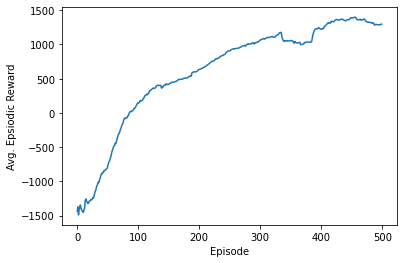

In [33]:
ep_reward_list = []

avg_reward_list = []


for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
    
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)


plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()


In [40]:
no_episodes=[]
for i in range(0,700):
    no_episodes.append(i)

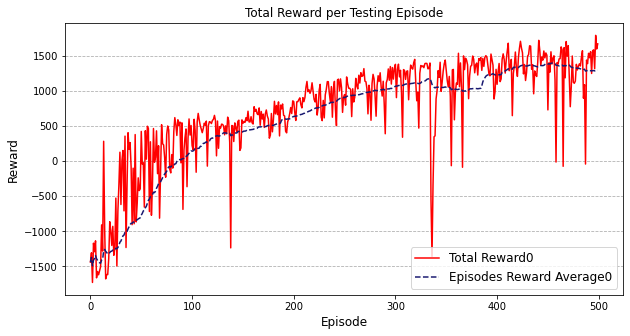

In [35]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,ep_reward_list, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_reward_list, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [36]:
actor_model.save('Cheetah_actor.h5')

In [37]:
critic_model.save('Cheetah_critic.h5')

In [38]:
for ep in range(500,700):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
    
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 500 * Avg Reward is ==> 1318.1714488483956
Episode * 501 * Avg Reward is ==> 1320.5825065772174
Episode * 502 * Avg Reward is ==> 1323.1363426276882
Episode * 503 * Avg Reward is ==> 1324.914377464224
Episode * 504 * Avg Reward is ==> 1327.3868113680908
Episode * 505 * Avg Reward is ==> 1330.720752027385
Episode * 506 * Avg Reward is ==> 1316.9254810235311
Episode * 507 * Avg Reward is ==> 1326.0672774441032
Episode * 508 * Avg Reward is ==> 1353.6581605197055
Episode * 509 * Avg Reward is ==> 1348.9286780839875
Episode * 510 * Avg Reward is ==> 1351.3389527383574
Episode * 511 * Avg Reward is ==> 1360.4409699190148
Episode * 512 * Avg Reward is ==> 1362.369846114073
Episode * 513 * Avg Reward is ==> 1356.567196824956
Episode * 514 * Avg Reward is ==> 1355.2263440128497
Episode * 515 * Avg Reward is ==> 1391.4225692689872
Episode * 516 * Avg Reward is ==> 1388.409054995289
Episode * 517 * Avg Reward is ==> 1396.6643286996123
Episode * 518 * Avg Reward is ==> 1351.901793713116

Episode * 656 * Avg Reward is ==> 1323.1995101312546
Episode * 657 * Avg Reward is ==> 1309.811024075309
Episode * 658 * Avg Reward is ==> 1306.5239997268316
Episode * 659 * Avg Reward is ==> 1297.6711940963326
Episode * 660 * Avg Reward is ==> 1291.4462257092396
Episode * 661 * Avg Reward is ==> 1291.4978460466386
Episode * 662 * Avg Reward is ==> 1287.110974474729
Episode * 663 * Avg Reward is ==> 1279.6322016278243
Episode * 664 * Avg Reward is ==> 1274.9020672382696
Episode * 665 * Avg Reward is ==> 1277.6434373659367
Episode * 666 * Avg Reward is ==> 1277.433252091231
Episode * 667 * Avg Reward is ==> 1273.6686969595617
Episode * 668 * Avg Reward is ==> 1277.695182570823
Episode * 669 * Avg Reward is ==> 1275.393190257384
Episode * 670 * Avg Reward is ==> 1270.7194434832425
Episode * 671 * Avg Reward is ==> 1272.4036578725866
Episode * 672 * Avg Reward is ==> 1264.7035989534568
Episode * 673 * Avg Reward is ==> 1257.73904995115
Episode * 674 * Avg Reward is ==> 1249.0467051835797


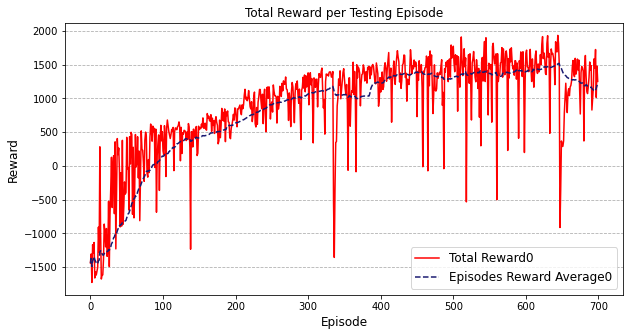

In [41]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,ep_reward_list, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_reward_list, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()